# BELGIUM TSC WITH TENSORFLOW

VAMOS A IMPLEMENTAR EL SIGUIENTE MODELO:  
LINEAR --> RELU 
Una única capa de 63 nodos igual al número de categorias

Las referencias utilizadas para esta hoja son:
+ Curso de deep neural networks de Andrw NG
+ Artículo sobre reconocimiento de imágenes de Walled Abdulla

El primer paso es preparar el DATASET para poder aplicar el DataFrame Tensorflow en el.

## PREPARANDO EL DATASET

In [5]:
import skimage.transform
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict


# Allow image embeding in notebook
%matplotlib inline

In [6]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    return images, labels

In [7]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)

In [8]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir)

X_nd=np.ndarray(shape=(len(X_32),len(X_32[0]),len(X_32[0]),3))
    for m in range (len(X_32)):
        a=X_32[0]
        for y in range(len(X_32[0])):
            for x in range(len(X_32[0])):
                for c in range(3):
                    X_nd[m,y,x,c]=a[y,x,c]

In [9]:
def prepare_X(X_train):
    
    # Resize and normalizing (RGB) images
    X_32 = [skimage.transform.resize(image, (32, 32))
                for image in X_train]
    #print('X_32[0].shape',X_32[0].shape)
    #print('32*32*3 =',32*32*3)
    
    
    #convertimos la lista a un array nd
    X_nd = np.array(X_32)
     
    
    #pasamos de un array de 4 dimensiones a uno de 2
    X_flatt = X_nd.reshape(X_nd.shape[0], -1).T
    
    return X_flatt

In [10]:
#COMPROBAMOS QUE LAS DIMENSIONES SEAN CORRECTAS
X_train=prepare_X(X_train_orig)
print('len(X_train_orig): ',len(X_train_orig))
print('32*32*3 =',32*32*3)
print('X_train.shape: ',X_train.shape)
X_test=prepare_X(X_test_orig)
print('tenemos 4575 imágnes de 3072 pixeles --> CORRECTO \n')
print('len(X_test_orig): ',len(X_test_orig))
print('32*32*3 =',32*32*3)
print('X-test.shape: ',X_test.shape)
print('tenemos 2520 imágnes de 3072 pixeles --> CORRECTO')

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


len(X_train_orig):  4575
32*32*3 = 3072
X_train.shape:  (3072, 4575)
tenemos 4575 imágnes de 3072 pixeles --> CORRECTO 

len(X_test_orig):  2520
32*32*3 = 3072
X-test.shape:  (3072, 2520)
tenemos 2520 imágnes de 3072 pixeles --> CORRECTO


In [11]:
def prepare_Y(Y, C):
    
    #convertimos a una matriz de one hot
    Z=np.zeros((len(Y),C))
    for i in range(len(Y)):
        Z[i,Y[i]] = 1
    return Z.T

In [12]:
#COMPROBAMOS QUE LAS DIMENSIONES SEAN CORRECTAS
Y_train=prepare_Y(Y_train_orig,len(set(Y_train_orig)))
print('len(Y_train_orig): ',len(Y_train_orig))
print('Y_train.shape: ',Y_train.shape)
print('tenemos 62 categorias y 4575 imágenes --> CORRECTO\n')
Y_test=prepare_Y(Y_test_orig,len(set(Y_train_orig)))
print('len(Y_test_orig): ',len(Y_test_orig))
print('Y_test.shape: ',Y_test.shape)
print('tenemos 62 categorias y 2520 imágenes --> CORRECTO')

len(Y_train_orig):  4575
Y_train.shape:  (62, 4575)
tenemos 62 categorias y 4575 imágenes --> CORRECTO

len(Y_test_orig):  2520
Y_test.shape:  (62, 2520)
tenemos 62 categorias y 2520 imágenes --> CORRECTO


Las matrices ya preparadas deben tener las siguientes dimensiones:  
X_train.shape = [(32x32x3) , 4575]  
X_test.sahpe = [(32x32x3) , 2520]  
Y_train.shape = (62 , 4575)  
Y_test.shape = (62 , 2520)

# MODELO

En este primer round del combate aplicaremos una única capa con 62 nodos (el número de categorias).  
Mezclamos el modelo de Walled Abdulla y el código de Andrew NG.

In [13]:
parametros_iniciales={"n_x":len(X_train),
                      "n_y":len(Y_train),
                      "m":len(X_train[0]),
                      "L1":62}

In [14]:
def create_placeholders(parametros_iniciales):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    parameters -- Python dictionary containing:
        n_x -- scalar, size of an image vector (num_px * num_px = 32*32 * 3 = 12288)
        n_y -- scalar, number of classes (from 0 to 62, so -> 62)
        l1 -- scalar, dimension of the first layer
        L2 -- scalar, dimension of the second layer
        L3 -- scalar, dimension of the third layer
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    n_x=parametros_iniciales["n_x"]
    n_y=parametros_iniciales["n_y"]
    
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,],name='Y')

 
    return X, Y

In [15]:
X, Y = create_placeholders(parametros_iniciales)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(3072, ?), dtype=float32)
Y = Tensor("Y:0", shape=(62,), dtype=float32)


In [22]:
def initialize_parameters(parametros_iniciales):
    """
    Arguments:
    parametros_inicales -- Python dictionary containing:
        n_x -- scalar, size of an image vector (num_px * num_px = 32*32 * 3 = 3072)
        n_y -- scalar, number of classes (from 0 to 62, so -> 62)
        L1 -- scalar, dimension of the first layer

    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1
    """
    
    #tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    n_x=parametros_iniciales["n_x"]
    n_y=parametros_iniciales["n_y"]
    L1=parametros_iniciales["L1"]

    
    
    
    W1 = tf.get_variable("W1", [L1,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = None))
    b1 = tf.get_variable("b1", [L1,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1}
    
    return parameters

In [23]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(parametros_iniciales)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))

W1 = <tf.Variable 'W1:0' shape=(62, 3072) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(62, 1) dtype=float32_ref>


In [24]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']

                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                        # Z1 = np.dot(W1, X) + b1
    #A1 = tf.nn.relu(Z1)
    
    #Implement the forward pass of the neural network. We commented for you the numpy equivalents
    #so that you can compare the tensorflow implementation to numpy. It is important to note that
    #the forward propagation stops at z3. The reason is that in tensorflow the last linear layer output
    #is given as input to the function computing the loss. Therefore, you don't need a3!
    
    return Z1

In [27]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(parametros_iniciales)
    parameters = initialize_parameters(parametros_iniciales)
    Z1 = forward_propagation(X, parameters)
    print("Z1 = " + str(Z1))

Z1 = Tensor("Add:0", shape=(62, ?), dtype=float32)


In [39]:
def compute_cost(Z1, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    #It is important to know that the "logits" and "labels" inputs of tf.nn.softmax_cross_entropy_with_logits
    #are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)
    

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,  labels = labels))
    
    print('logiTS',logits)
    print('labels',labels)
    
      
    return cost

In [40]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(parametros_iniciales)
    parameters = initialize_parameters(parametros_iniciales)
    Z1 = forward_propagation(X, parameters)
    cost = compute_cost(Z1, Y)

    print("cost = " + str(cost))

logist Tensor("transpose:0", shape=(?, 62), dtype=float32)
labels Tensor("transpose_1:0", shape=(62,), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


In [38]:
def model(X_train, Y_train, X_test, Y_test, parametros_iniciales, learning_rate = 0.001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                             # to keep consistent results
    #seed = 3                                          # to keep consistent results
    n_x= parametros_iniciales["n_x"]                          # (n_x: input size, m : number of examples in the train set)
    n_y = parametros_iniciales["n_y"]                            # n_y : output size
    m=parametros_iniciales["m"]
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(parametros_iniciales)

    # Initialize parameters
    parameters = initialize_parameters(parametros_iniciales)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    A1 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(A1, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    #print('Y_train.shape',Y_train.shape)
    #print('X_train.shape',X_train.shape)

    # Start the session to compute the tensorflow graph
    
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                #print(minibatch_X.shape)
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        

        
        return parameters

# DATASET COMPLETO

Ejecutamos el modelo con el dataset completo, las 32 categorias.

In [29]:
print(len(Y_train))

62


In [40]:
parametros_iniciales={"n_x":len(X_train),
                      "n_y":len(Y_train),
                      "m":len(X_train[0]),
                      "L1":62}


In [41]:
parameters = model(X_train, Y_train, X_test, Y_test,parametros_iniciales)

Cost after epoch 0: 4.125371
Cost after epoch 100: 4.118964


KeyboardInterrupt: 

0.082 de ACCURACY!!! MUY MAL

Parece que el coste converge muy rapido a 3.62 y varía muy poco con las epochs succesivos.  
Tenemos un learning rate muy bajo, puede que nos hayamos atascado en un mínimo local.

Cost after epoch 0: 9.934310
Cost after epoch 100: 3.658386
Cost after epoch 200: 3.657944
Cost after epoch 300: 3.653208
Cost after epoch 400: 3.660821
Cost after epoch 500: 3.661104
Cost after epoch 600: 3.657545
Cost after epoch 700: 3.658551
Cost after epoch 800: 3.658720
Cost after epoch 900: 3.658173
Cost after epoch 1000: 3.660375
Cost after epoch 1100: 3.662266
Cost after epoch 1200: 3.656960
Cost after epoch 1300: 3.657508
Cost after epoch 1400: 3.657442


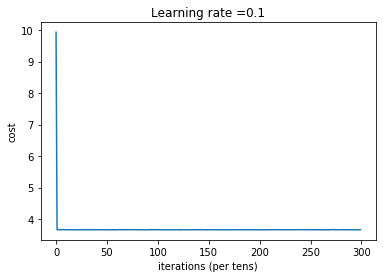

Parameters have been trained!
Train Accuracy: 0.08196721
Test Accuracy: 0.02420635


In [103]:
parameters = model(X_train, Y_train, X_test, Y_test,parametros_iniciales, learning_rate=0.1)

Parece que cambiando el learning_rate no conseguimos mejorar, acabamos en lo que parece el mismo mínimo local.  

Podemos observar que el coste de los dos casos tiende hacia el mismo sitio (3.65).  
Puede que se deba a que inicializador tiene un random seed establecido para poder comparar los resultados.    
Vamos a quitar el random seed predeterminado a ver que pasa.  
También observamos que en el epoch 200 ya no varia mucho.  
Si reducimos el nº de epochs podremos aumentar el tiempo entre iteraciones.

In [45]:
parametros_iniciales={"n_x":len(X_train),
                      "n_y":len(Y_train),
                      "m":len(X_train[0]),
                      "L1":100,
                      "L2":80,
                      "L3":62}

Cost after epoch 0: 4.136390
Cost after epoch 100: 3.626291
Cost after epoch 200: 3.625470
Cost after epoch 300: 3.625147
Cost after epoch 400: 3.625169


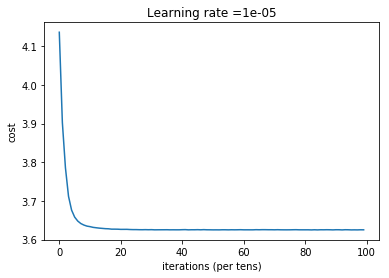

Parameters have been trained!
Train Accuracy: 0.08196721
Test Accuracy: 0.041666668


In [46]:
parameters = model(X_train, Y_train, X_test, Y_test,parametros_iniciales, learning_rate=0.00001, num_epochs=500)

Parece que no era problema del inicializador.  
El coste se aproxima a los que hemos estado viendo.

El modelo que hemos creado es muy simple  y puede que no sea capaz de representar la complejidad del problema.  
Podríamos probar de reducir el número de categorías y ver si simplificando el problema mejoramos algo.

## SIMPLIFYING THE DATASET

Para esta simplificación vamos a escoger tres tipos de señales con distintos formatos para ver si el modelo presponde.  
Las categorias que vamos a utilizar son: 1(110), 19(231), 22(375), 32(316), 39(196) y 47(147)  
En total tenemos 1375 ejemplos.  
Intentamos elegir categorias que tengan gran cantidad de ejemplos y que tenga formatos y colores distintos.

In [19]:
def dataset_slice(X_orig,Y_orig,X_slice,Y_slice,cat):
    for i in range(len(Y_orig)):
        #print(Y_orig)
        if Y_orig[i] == cat:
            X_slice.append(X_orig[i])
            Y_slice.append(Y_orig[i])
    return X_slice, Y_slice

In [20]:
#sliing train dataset
X_train_slice=[]
Y_train_slice=[]
categories = [1,19,22,32,39,47]
for category in categories:
    #print(category)
    X_train_slice,Y_train_slice=dataset_slice(X_train_orig,Y_train_orig,X_train_slice,Y_train_slice,category)

In [21]:
#sliing test dataset
X_test_slice=[]
Y_test_slice=[]
categories = [1,19,22,32,39,47]
for category in categories:
    X_test_slice,Y_test_slice=dataset_slice(X_test_orig,Y_test_orig,X_test_slice,Y_test_slice,category)

In [22]:
#preparing the dataset
X_train_slice=prepare_X(X_train_slice)
X_test_slice=prepare_X(X_test_slice)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


X_32[0].shape (32, 32, 3)
32*32*3 = 3072
X_32[0].shape (32, 32, 3)
32*32*3 = 3072


In [23]:
print(X_train_slice.shape)

(3072, 1375)


In [24]:
def prepare_Y_slice(Y,C):
    Z=np.zeros((len(Y),C))
    for i in range(len(Y)):
        if Y[i]==1:
            Z[i,0] = 1
        if Y[i]==19:
            Z[i,0] = 1
        if Y[i]==22:
            Z[i,1] = 1
        if Y[i]==32:
            Z[i,1] = 1
        if Y[i]==39:
            Z[i,1] = 1
        if Y[i]==47:
            Z[i,2] = 1
    return Z.T

In [25]:
Y_train_slice=prepare_Y_slice(Y_train_slice,len(set(Y_train_slice)))
Y_test_slice=prepare_Y_slice(Y_test_slice,len(set(Y_test_slice)))

In [26]:
parametros_iniciales={"n_x":len(X_train_slice),
                      "n_y":len(Y_train_slice),
                      "m":len(X_train_slice[0]),
                      "L1":25,
                      "L2":12,
                      "L3":6}

Cost after epoch 0: 2.202867
Cost after epoch 100: 1.589275
Cost after epoch 200: 1.501430
Cost after epoch 300: 1.416084
Cost after epoch 400: 1.329784
Cost after epoch 500: 1.265330
Cost after epoch 600: 1.208353
Cost after epoch 700: 1.155924
Cost after epoch 800: 1.107382
Cost after epoch 900: 1.064298
Cost after epoch 1000: 1.028209
Cost after epoch 1100: 0.998766
Cost after epoch 1200: 0.975274
Cost after epoch 1300: 0.957056
Cost after epoch 1400: 0.942961
Cost after epoch 1500: 0.931959
Cost after epoch 1600: 0.923488
Cost after epoch 1700: 0.916954
Cost after epoch 1800: 0.911814
Cost after epoch 1900: 0.907599
Cost after epoch 2000: 0.904314
Cost after epoch 2100: 0.901584
Cost after epoch 2200: 0.899355
Cost after epoch 2300: 0.897468
Cost after epoch 2400: 0.896062
Cost after epoch 2500: 0.894907
Cost after epoch 2600: 0.893783
Cost after epoch 2700: 0.893023
Cost after epoch 2800: 0.892337
Cost after epoch 2900: 0.891691


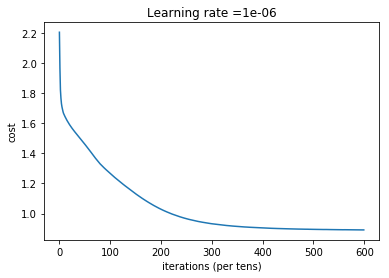

Parameters have been trained!
Train Accuracy: 0.64509094
Test Accuracy: 0.72478205


In [42]:
parameters = model(X_train_slice, Y_train_slice, X_test_slice, Y_test_slice,parametros_iniciales, learning_rate=0.000001, num_epochs=3000, minibatch_size = 32)

NO ESTÁ MAL....  
Después de tunear un poco el learning rate, conseguimos un train accurac de 65%.

TRAINING ERROR: 65%  
TEST ERROR: 73%

BYES ERROR  
En este tipo de problemas el error optimo de Byes (el mínimo posible) estaría alrededor de un 0-0.5 %, los humanos somos muy buenos reconociendo imágenes.  
Con este mismo modelo pero utilizando imágenes más limpias del SIGNS dataset Andrew NG consigue un 99% acierto.  
El model utilizado por Walled Abdulla en este mismo dataset y con todas las categorias consigue entre un 40 y un 70%.  
Comparando el error de Andrew Y Walled deducimos que nuestro dataset es más complicado. Andrew consigue un mayor acierto con un modelo mucho más simple que Walled.  
Podemos considerar que el Byes error para este "slice" del dataset y con este modelo está entorno a un 80-90%.  
Idealmente, deberíamos conseguir ese porcentaje.

RANDOM GUESS  
Dado que tenemos 6 categorias, un random guess tiene un 16,6% de probabilidades de acertar.

Tenemos un avoidable bias muy grande aún 15-20%.  
Pero observamos como nuestro modelo lo hace bastante mejor que un random guess.  

Este acierto lo hemos conseguido simplemente tuneando el learning rate. Podemos deducir que el potencial del modelo es algo mayor de lo que hemos conseguido ahora.  
De momento tenemos tres hyperparametros:
+ El número de capas
+ La dimensión de las capas
+ Minibatch_size.

TRAIN ACCURACY < TEST ACCURACY  
Parece que la precisión del test es mayor que la del train.  
Esto es muy extraño, debería ser justo lo contrario.  
Puede que sea debido a que las imágenes del test son de mayor calidad, deberíamos comprobarlo.

In [56]:
parametros_iniciales={"n_x":len(X_train_slice),
                      "n_y":len(Y_train_slice),
                      "m":len(X_train_slice[0]),
                      "L1":50,
                      "L2":25,
                      "L3":6}

Cost after epoch 0: 1.654354
Cost after epoch 100: 1.616659
Cost after epoch 200: 1.581879
Cost after epoch 300: 1.549967
Cost after epoch 400: 1.531537
Cost after epoch 500: 1.513215
Cost after epoch 600: 1.498201
Cost after epoch 700: 1.485425
Cost after epoch 800: 1.473824
Cost after epoch 900: 1.462628


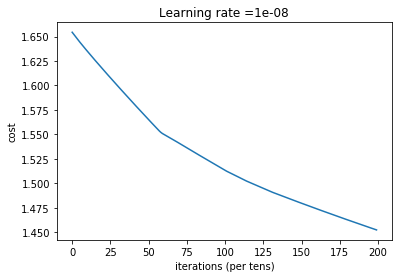

Parameters have been trained!
Train Accuracy: 0.64509094
Test Accuracy: 0.72478205


In [55]:
parameters = model(X_train_slice, Y_train_slice, X_test_slice, Y_test_slice,parametros_iniciales, learning_rate=0.00000001, num_epochs=1000)

ME DA EL MISMO TRAIN ACCURACY....  
ESTO ES MUY RARO  
Voy a volver a ejecutar el modelo para ver si ha sido casualidad.

Cost after epoch 0: 1.614893
Cost after epoch 100: 1.552912
Cost after epoch 200: 1.499389
Cost after epoch 300: 1.449871
Cost after epoch 400: 1.405036
Cost after epoch 500: 1.363934
Cost after epoch 600: 1.327102
Cost after epoch 700: 1.293590
Cost after epoch 800: 1.259216
Cost after epoch 900: 1.229243


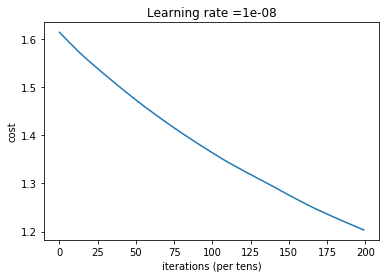

Parameters have been trained!
Train Accuracy: 0.64509094
Test Accuracy: 0.72478205


In [57]:
parameters = model(X_train_slice, Y_train_slice, X_test_slice, Y_test_slice,parametros_iniciales, learning_rate=0.00000001, num_epochs=1000)

El coste es muy alto pero me da exactamente el mismo train accurac....  
Reseteo el Kernel y vuelvo a ejecutar cambiando algo los parametros.

In [27]:
parametros_iniciales={"n_x":len(X_train_slice),
                      "n_y":len(Y_train_slice),
                      "m":len(X_train_slice[0]),
                      "L1":50,
                      "L2":25,
                      "L3":6}

Cost after epoch 0: 1.542269
Cost after epoch 100: 0.967371
Cost after epoch 200: 0.917862
Cost after epoch 300: 0.909514
Cost after epoch 400: 0.907188


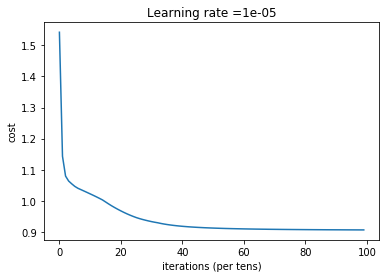

Parameters have been trained!
Train Accuracy: 0.64509094
Test Accuracy: 0.72478205


In [28]:
tf.reset_default_graph()
parameters = model(X_train_slice, Y_train_slice, X_test_slice, Y_test_slice,parametros_iniciales, learning_rate=0.00001, num_epochs=500, minibatch_size = 64)

## <font color='red'>@M. CUARTAS <font color='red'> 
Me da el mismo error aunque aumente la capas...   
QUE ESTA PASANDO???



## AUMENTAMOS LA COMPLEJIDAD DEL MODELO

Añadimos más capas

In [53]:
def initialize_parameters(parametros_iniciales):
    """
    Arguments:
    parametros_inicales -- Python dictionary containing:
        n_x -- scalar, size of an image vector (num_px * num_px = 32*32 * 3 = 3072)
        n_y -- scalar, number of classes (from 0 to 62, so -> 62)
        L1 -- scalar, dimension of the first layer
        L2 -- scalar, dimension of the second layer
        L3 -- scalar, dimension of the third layer
    
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [1000, 3072]
                        b1 : [1000, 1]
                        W2 : [500, 1000]
                        b2 : [500, 1]
                        W3 : [62, 500]
                        b3 : [61, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    #tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    n_x=parametros_iniciales["n_x"]
    n_y=parametros_iniciales["n_y"]
    L1=parametros_iniciales["L1"]
    L2=parametros_iniciales["L2"]
    L3=parametros_iniciales["L3"]
    L4=parametros_iniciales["L4"]
    L5=parametros_iniciales["L5"]
    
    
    
    W1 = tf.get_variable("W1", [L1,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [L1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [L2,L1], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [L2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [L3,L2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [L3,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable("W4", [L4,L3], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [L4,1], initializer = tf.zeros_initializer())
    W5 = tf.get_variable("W5", [L5,L4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b5 = tf.get_variable("b5", [L5,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5}
    
    return parameters

In [54]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                        # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                       # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                       # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4,A3),b4)                       
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5,A4),b5)
    
    
    return Z5

In [55]:
def model(X_train, Y_train, X_test, Y_test,parametros_iniciales, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                             # to keep consistent results
    #seed = 3                                          # to keep consistent results
    n_x= parametros_iniciales["n_x"]                          # (n_x: input size, m : number of examples in the train set)
    n_y = parametros_iniciales["n_y"]                            # n_y : output size
    m=parametros_iniciales["m"]
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(parametros_iniciales)

    # Initialize parameters
    parameters = initialize_parameters(parametros_iniciales)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    #print(Z3)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    #print('Y_train.shape',Y_train.shape)
    #print('X_train.shape',X_train.shape)

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                #print(minibatch_X.shape)
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [56]:
parametros_iniciales={"n_x":len(X_train_slice),
                      "n_y":len(Y_train_slice),
                      "m":len(X_train_slice[0]),
                      "L1":200,
                      "L2":100,
                      "L3":70,
                      "L4":30,
                      "L5":3,}

Cost after epoch 0: 1.181403
Cost after epoch 100: 1.134228
Cost after epoch 200: 1.133808
Cost after epoch 300: 1.133369
Cost after epoch 400: 1.133202
Cost after epoch 500: 1.133063
Cost after epoch 600: 1.132992
Cost after epoch 700: 1.132997
Cost after epoch 800: 1.132966
Cost after epoch 900: 1.132963


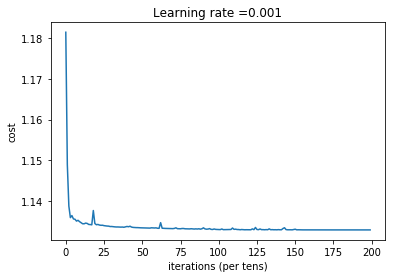

Parameters have been trained!
Train Accuracy: 0.45924452
Test Accuracy: 0.66530615


In [57]:
parameters = model(X_train_slice, Y_train_slice, X_test_slice, Y_test_slice,parametros_iniciales, learning_rate=0.001, num_epochs=1000)

# SIGNS DATASET

Parece que puede haber un error.  
Para comprobarlo vamos a utilizar el SIGNS dataset de Andrew NG y ver si conseguimos un 90% que es lo que el consiguió

In [30]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


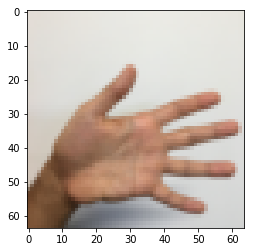

In [31]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [32]:
# Flatten the training and test images
#print('X_train_orig',X_train_orig)
#print('NÚMERO DE FOTOS --> len(X_train_orig):',len(X_train_orig))
#print('LONGITUD DEL PRIMER EJEMPLO --> len(X_train_orig[0]):',len(X_train_orig[0]))
#print('LONGITUD DEL ÚLTIMO EJEMPLO --> len(X_train_orig[1079]):',len(X_train_orig[1079]))
#print('PRIMER EJEMPLO --> X_train_orig[0,0]:',X_train_orig[0,0])
#print('PRIMER EJEMPLO --> X_train_orig[0][0]:',X_train_orig[0][0])
#print('LONGITUD DEL PRIMER ELEMENTO --> len(X_train_orig[0,0]):',len(X_train_orig[0,0]))
#print('LONGITUD DEL PRIMER ELEMENTO --> len(X_train_orig[0][0]):',len(X_train_orig[0][0]))
#print('PRIMER VECTOR DEL PRIMER ELEMENTO --> X_train_orig[0,0,0]:',X_train_orig[0,0,0])
#print('LONGITUD VECTOR DEL PRIMER ELEMENTO --> len(X_train_orig[0,0,0]):',len(X_train_orig[0,0,0]))
#print('TENEMOS 1080 EJEMPLOS (LISTAS) \nQUE CONTIENEN UNA MATRIZ DE 64x64 \nVECTORES QUE TIENEN LOS VALORES RGB DE CADA PIXEL')

#print('\n\nLONGITUD DE LA PRIMERA DIMENSIÓN (nº ejemplos) --> X_train_orig.shape[0]:',X_train_orig.shape[0])
#print('X_train_orig[0]',X_train_orig[0])
#print('X_train_orig[1079]',X_train_orig[1079])
#print('LONGITUD DE LA SEGUNDA DIMENSIÓN (nº filas por foto) --> X_train_orig.shape[1]',X_train_orig.shape[1])
#print('LONGITUD DE LA TERCERA DIMENSIÓN (nº columnas por fotos) --> X_train_orig.shape[2]',X_train_orig.shape[2])
#print('LONGITUD DE LA CUARTA DIMENSION (valores RGB de cada pixel) --> X_train_orig.shape[3]',X_train_orig.shape[3])
#print('X_train_orig.shape[1,1]',X_train_orig.shape[1,1])
#print('X_train_orig.shape[4]',X_train_orig.shape[4])

##TODO LO ANTERIOR SE PUEDE RESUMIR EN:
print('NÚMERO DE DIMENSIONES DEL DATASET\n X_train_orig.ndim:',X_train_orig.ndim)
print('\nLONGITUD DE LAS DIMENSIONES DEL DATASET\n X_train:orig.shape:',X_train_orig.shape,'\n\n')

X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
print('64*64*3=',64*64*3)
print('X_train_flatten.ndim:',X_train_flatten.ndim)
print('X_train_flatten.shape:',X_train_flatten.shape)
print('X_test_flatten.ndim:',X_test_flatten.ndim)
print('X_test_flatten.shpae:',X_test_flatten.shape)
#print(X_train_flatten)
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)
print('\n\nY_train.ndim:',Y_train.ndim)
print('Y_train.shape:',Y_train.shape)
print('Y_test.ndim:',Y_test.ndim)
print('Y_test.shpae:',Y_test.shape)

print ("\n\nnumber of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

NÚMERO DE DIMENSIONES DEL DATASET
 X_train_orig.ndim: 4

LONGITUD DE LAS DIMENSIONES DEL DATASET
 X_train:orig.shape: (1080, 64, 64, 3) 


64*64*3= 12288
X_train_flatten.ndim: 2
X_train_flatten.shape: (12288, 1080)
X_test_flatten.ndim: 2
X_test_flatten.shpae: (12288, 120)


Y_train.ndim: 2
Y_train.shape: (6, 1080)
Y_test.ndim: 2
Y_test.shpae: (6, 120)


number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [55]:
parametros_iniciales={"n_x":len(X_train),
                      "n_y":len(Y_train),
                      "m":len(X_train[0]),
                      "L1":25,
                      "L2":12,
                      "L3":6,}

In [35]:
X, Y = create_placeholders(parametros_iniciales)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(6, ?), dtype=float32)


In [45]:
def initialize_parameters(parametros_iniciales):
    """
    Arguments:
    parametros_inicales -- Python dictionary containing:
        n_x -- scalar, size of an image vector (num_px * num_px = 32*32 * 3 = 3072)
        n_y -- scalar, number of classes (from 0 to 62, so -> 62)
        L1 -- scalar, dimension of the first layer
        L2 -- scalar, dimension of the second layer
        L3 -- scalar, dimension of the third layer
    
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [1000, 3072]
                        b1 : [1000, 1]
                        W2 : [500, 1000]
                        b2 : [500, 1]
                        W3 : [62, 500]
                        b3 : [61, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    n_x=parametros_iniciales["n_x"]
    n_y=parametros_iniciales["n_y"]
    L1=parametros_iniciales["L1"]
    L2=parametros_iniciales["L2"]
    L3=parametros_iniciales["L3"]
    
    
    
    W1 = tf.get_variable("W1", [L1,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [L1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [L2,L1], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [L2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [L3,L2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [L3,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [37]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(parametros_iniciales)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [38]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                        # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                       # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                       # Z3 = np.dot(W3,Z2) + b3

    
    
    
    return Z3

In [40]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(parametros_iniciales)
    parameters = initialize_parameters(parametros_iniciales)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [42]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(parametros_iniciales)
    parameters = initialize_parameters(parametros_iniciales)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [47]:
def model(X_train, Y_train, X_test, Y_test,parametros_iniciales, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    n_x= parametros_iniciales["n_x"]                          # (n_x: input size, m : number of examples in the train set)
    n_y = parametros_iniciales["n_y"]                            # n_y : output size
    m=parametros_iniciales["m"]
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(parametros_iniciales)

    # Initialize parameters
    parameters = initialize_parameters(parametros_iniciales)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    #print(Z3)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    #print('Y_train.shape',Y_train.shape)
    #print('X_train.shape',X_train.shape)

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size,seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                #print(minibatch_X.shape)
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.888744
Cost after epoch 100: 1.846065
Cost after epoch 200: 1.846065
Cost after epoch 300: 1.846064
Cost after epoch 400: 1.846064


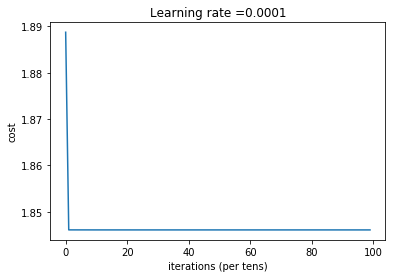

Parameters have been trained!
Train Accuracy: 0.16666667
Test Accuracy: 0.16666667


In [44]:
parameters = model(X_train, Y_train, X_test, Y_test, parametros_iniciales, num_epochs = 500, minibatch_size = 32)

Utilizando exactamente los mismos modelos, nos ha pasado lo mismo.  
Parece que converge de forma muy rapida hacia un numero en concreto y se queda allí.  
Vamos a resestablecer el tema de los seeds a su estado original (como en el ejercicio de Andrew) para ver si el problema viene de allí.

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102


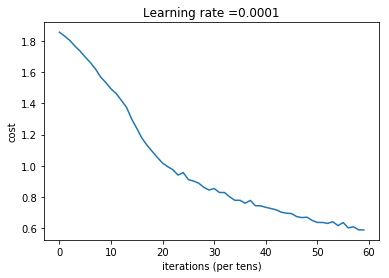

Parameters have been trained!
Train Accuracy: 0.8277778
Test Accuracy: 0.75


In [57]:
parameters = model(X_train, Y_train, X_test, Y_test, parametros_iniciales, num_epochs = 300, minibatch_size = 32)

No he dejado que el modelo siga, solo he hecho 300 epochs, pero cuadra perfectamente.

PARECE QUE EL MODELO NO TIENE NINGÚN PROBLEMA....

¿POR QUE SIGO TENINDO EXACTAMENTE EL MISMO ACCURACY?